In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import community as community_louvain
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import fa2_modified as fa2
import re
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import math
from wordcloud import WordCloud
import random

random_state = 2137
random.seed(random_state)
np.random.seed(random_state)

No cython detected.  Install cython and compile the fa2util module for a 10-100x speed boost.


## Load processed graph

In [3]:
# Path to your pickle file
pickle_file_path = "graphs/researchers_csai_graph_gcc_with_abstract.pkl"

with open(pickle_file_path, "rb") as f:
    G = pickle.load(f)

In [4]:
print(f'Graph has {len(G.nodes())} nodes')
print(f'Graph has {len(G.edges())} edges')

Graph has 162972 nodes
Graph has 2338729 edges


## Citations

In [5]:
# Dictionary to store unique titles and their citation counts
unique_citations = {}

# Iterate over all edges
for u, v, edge_data in G.edges(data=True):
    # Access title and citation count
    title = edge_data.get('title', None)
    num_cited_by = edge_data.get('numCitedBy', 0)  # Default to 0 if not present
    
    # Ensure title is valid (not None or empty)
    if title:
        if title not in unique_citations:
            unique_citations[title] = num_cited_by
        else:
            # If title is already seen, skip or handle duplicates (e.g., take max, sum, etc.)
            pass

# Count frequencies of citation counts
citation_freq = {}
for citation in unique_citations.values():
    if citation in citation_freq:
        citation_freq[citation] += 1
    else:
        citation_freq[citation] = 1

# Sort the citation frequencies by citation count (ascending order)
sorted_citation_freq = sorted(citation_freq.items())


The following part adds `citations` node feature which sums citations from distinct papers related to the researcher.

In [ ]:
# Initialize a dictionary to hold citation counts for each node
node_citations = {node: 0 for node in G.nodes()}

# Iterate over all edges in the graph
for u, v, edge_data in G.edges(data=True):
    # Access title and citation count
    title = edge_data.get('title', None)
    num_cited_by = edge_data.get('numCitedBy', 0)  # Default to 0 if not present

    # Ensure title is valid (not None or empty)
    if title:
        # Ensure citations are only counted once per unique title
        if title not in unique_citations:
            unique_citations[title] = num_cited_by
            # Add the citation count to both nodes (u and v)
            node_citations[u] += num_cited_by
            node_citations[v] += num_cited_by

nx.set_node_attributes(G, node_citations, 'citations')

In [7]:
# Extract citation counts from the deduplicated data
deduplicated_citation_counts = list(unique_citations.values())

plt.figure(figsize=(10, 6))
plt.hist(
    deduplicated_citation_counts,
    bins=30,
    color="royalblue",
    alpha=0.7,
    edgecolor="black"
)

plt.yscale("log")

plt.title("Citations Distribution", fontsize=14)
plt.xlabel("Number of Citations", fontsize=12)
plt.ylabel("Number of Papers", fontsize=12)

plt.show()

As expected, we have a seriousely right-skewed citations distribution. Few papers enjoy very high number of citations and most papers get only a couple.

In [8]:
# Extract deduplicated citation data and associated paper metadata
deduplicated_paper_citations = [
    (title, num_cited_by) for title, num_cited_by in unique_citations.items()
]

# Sort papers by citation count in descending order
sorted_deduplicated_papers = sorted(
    deduplicated_paper_citations, key=lambda x: x[1], reverse=True
)

# Get the top 10 papers
top_10_papers = sorted_deduplicated_papers[:10]

# Print the top 10 papers
print("Top Papers with Most Citations (Deduplicated by Title):\n")
for i, (title, citations) in enumerate(top_10_papers, 1):
    print(f"{i}. {title} - Citations: {citations}")

Top Papers with Most Citations (Deduplicated by Title):

1. An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale - Citations: 31414
2. SMOTE: Synthetic Minority Over-sampling Technique - Citations: 23278
3. A Unified Approach to Interpreting Model Predictions - Citations: 17703
4. Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification - Citations: 17689
5. Graph Attention Networks - Citations: 17607
6. Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization - Citations: 17416
7. “Why Should I Trust You?”: Explaining the Predictions of Any Classifier - Citations: 15069
8. Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks - Citations: 10801
9. Conditional Generative Adversarial Nets - Citations: 9774
10. Training language models to follow instructions with human feedback - Citations: 9614


TO DO: 
- Do small research on them to tell a story. Looks like these are well aclaimed papers.

In [9]:
# Dictionary to store total citations for each researcher
researcher_citations = defaultdict(int)

# Dictionary to track papers already counted for each researcher
researcher_papers = defaultdict(set)

# Traverse edges to aggregate citation counts for each researcher
for u, v, edge_data in G.edges(data=True):
    # Access citation-related attributes and title
    title = edge_data.get('title')
    num_cited_by = edge_data.get('numCitedBy', 0)
    
    # Ensure the title is valid
    if title:
        # Add citations for each researcher, ensuring the paper is counted only once
        if title not in researcher_papers[u]:
            researcher_citations[u] += num_cited_by
            researcher_papers[u].add(title)
        if title not in researcher_papers[v]:
            researcher_citations[v] += num_cited_by
            researcher_papers[v].add(title)

# Sort researchers by total citations (descending)
sorted_researcher_citations = sorted(researcher_citations.items(), key=lambda x: x[1], reverse=True)

# Print the top researchers by total citations
print("Top Researchers by Total Citations (Deduplicated by Paper):\n")
for i, (researcher, total_citations) in enumerate(sorted_researcher_citations[:10], 1):  # Adjust the range for more/less
    print(f"{i}. {researcher} - Total Citations: {total_citations}")


Top Researchers by Total Citations (Deduplicated by Paper):

1. S. Levine - Total Citations: 66585
2. P. Abbeel - Total Citations: 59345
3. Alexey Dosovitskiy - Total Citations: 41593
4. Quoc V. Le - Total Citations: 38176
5. Lucas Beyer - Total Citations: 36650
6. Xiaohua Zhai - Total Citations: 36520
7. N. Houlsby - Total Citations: 36510
8. Alexander Kolesnikov - Total Citations: 36492
9. Mostafa Dehghani - Total Citations: 36346
10. Yoshua Bengio - Total Citations: 36330


TO DO: 
- Look into whether it is one or many papers for them. 
- Do small research for a story. 
- No women? - cover on that.

## Filter out low citations edges

From now on, we are focusing only on the most valuable papers judged by number of citations. We are filtering out papers with less than 25 citations.

In [10]:
# Find edges with below 25 citations
edges_to_remove = [
    (u, v) for u, v, edge_data in G.edges(data=True) if edge_data.get("numCitedBy", 0) < 25
]

# # Copy graph and remove edges
G_filtered = G.copy()
G_filtered.remove_edges_from(edges_to_remove)

In [11]:
connected_components = list(nx.connected_components(G_filtered))

# Identify the largest connected component (the giant component)
giant_component = max(connected_components, key=len)

# Create a subgraph for the giant component
RG = G_filtered.subgraph(giant_component).copy()

In [12]:
print(f'Filtered graph has {len(RG.nodes())} nodes')
print(f'Filtered graph has {len(RG.edges())} edges')

Filtered graph has 39314 nodes
Filtered graph has 1015840 edges


In [13]:
# Set to store unique titles
unique_titles = set()

# Iterate over all edges in the RG graph
for _, _, edge_data in RG.edges(data=True):
    # Access the title
    title = edge_data.get('title', None)
    
    # Ensure the title is valid and add it to the set
    if title:
        unique_titles.add(title)

# Number of unique papers (deduplicated edges)
num_unique_papers = len(unique_titles)

print(f"Number of unique papers: {num_unique_papers}")

Number of unique papers: 26709


## Degree distribution

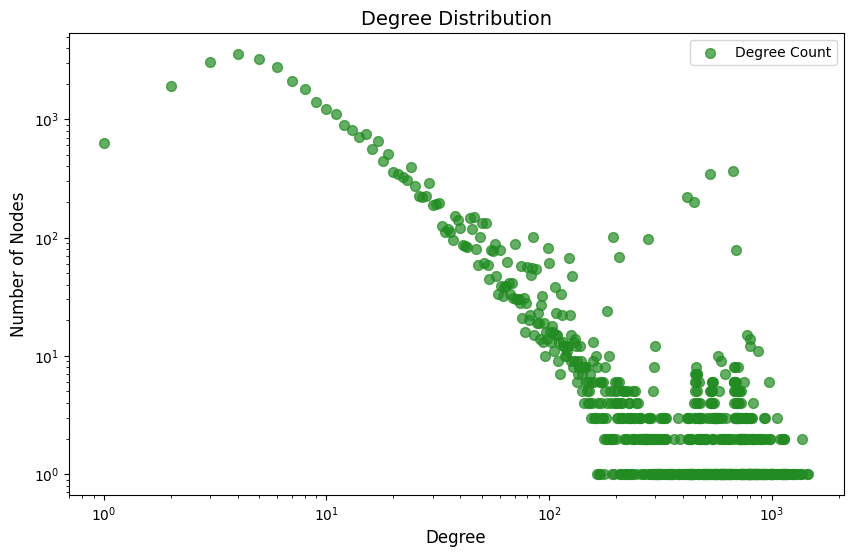

In [14]:
# Get the degree of each node
degrees = [d for _, d in RG.degree()]

# Count the frequency of each degree
degree_counts = {}
for degree in degrees:
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# Prepare data for plotting
degrees = list(degree_counts.keys())
counts = list(degree_counts.values())

# Plot the degree distribution as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degrees, counts, color="forestgreen", alpha=0.7, s=50, label="Degree Count")

# Set both axes to log scale
plt.xscale("log")
plt.yscale("log")

# Title and labels
plt.title("Degree Distribution", fontsize=14)
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)

# Add a legend and grid
plt.legend()

# Show the plot
plt.show()

Power-law degree distribution. We are dealing with scale-free network.

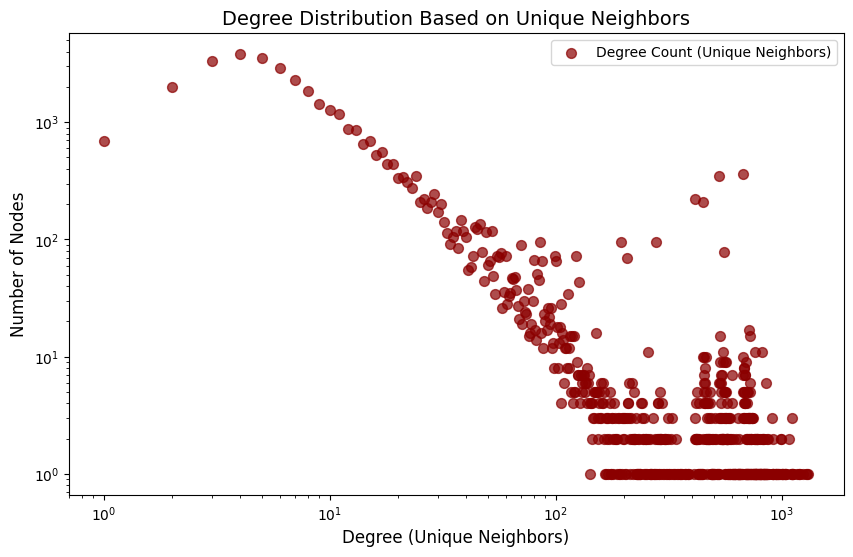

In [15]:
# Calculate degree based on unique neighbors
unique_neighbor_degrees = {node: len(set(RG.neighbors(node))) for node in RG.nodes()}

# Count the frequency of each degree
degree_counts = {}
for degree in unique_neighbor_degrees.values():
    if degree in degree_counts:
        degree_counts[degree] += 1
    else:
        degree_counts[degree] = 1

# Prepare data for plotting
degrees = list(degree_counts.keys())
counts = list(degree_counts.values())

# Plot the degree distribution as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degrees, counts, color="darkred", alpha=0.7, s=50, label="Degree Count (Unique Neighbors)")

# Set both axes to log scale
plt.xscale("log")
plt.yscale("log")

# Title and labels
plt.title("Degree Distribution Based on Unique Neighbors", fontsize=14)
plt.xlabel("Degree (Unique Neighbors)", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)

# Add a legend and grid
plt.legend()

# Show the plot
plt.show()

This second graph is calculated based on unique neighbours rather than number of edges. It does matter in case of MultiGraph but turns out the results are almost the same. This means that if we were to disregard multiple papers between two given researchers and just focus on whether they colaborated it wouldn't change the results in terms of degree.

TO DO: 
- In multigraphs, two nodes can have multiple edges between them. Check how it impacts the degree.
- Address the friendship paradox?

In [16]:
# Compute the degrees of all nodes
degrees = dict(RG.degree())

# Sort nodes by degree in descending order
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Get the top 5 nodes
top_10_nodes = sorted_degrees[:10]

# Display results
print("Top 10 nodes with highest degree:\n")
for node, degree in top_10_nodes:
    print(f"{node} - {degree}")

Top 10 nodes with highest degree:

Siamak Shakeri - 1462
Noah Fiedel - 1439
O. Vinyals - 1368
Ambrose Slone - 1368
Behnam Neyshabur - 1366
D. Hassabis - 1347
Michael B. Chang - 1344
Andrew M. Dai - 1285
Ethan Dyer - 1268
Vedant Misra - 1262


In [17]:
# Compute the number of unique neighbors for each node
unique_neighbors = {node: len(set(RG.neighbors(node))) for node in RG.nodes()}

# Sort nodes by the number of unique neighbors in descending order
sorted_unique_neighbors = sorted(unique_neighbors.items(), key=lambda x: x[1], reverse=True)

# Get the top 5 nodes
top_10_nodes = sorted_unique_neighbors[:10]

# Display results
print("Top 10 nodes with the most unique neighbors:\n")
for node, count in top_10_nodes:
    print(f"{node} - {count}")

Top 10 nodes with the most unique neighbors:

Siamak Shakeri - 1311
Noah Fiedel - 1297
Behnam Neyshabur - 1283
Ambrose Slone - 1241
Andrew M. Dai - 1210
Ethan Dyer - 1193
Vedant Misra - 1191
Luheng He - 1171
Harsh Mehta - 1122
Rosanne Liu - 1119


Although both prints include similar reserachers the second print seems better for interpretation. It says that these researchers collaborated with the highest number of other researchers withing AI space.

TO DO:
- check if it is because of high average number of collaborations on paper or many papers

## Convert MultiGraph to regular Graph for some parts of analysis

In [18]:
# Convert the multigraph to a regular graph where two nodes can have only one edge
RG_regular = nx.Graph(RG)

In [19]:
print(f'RG Multigraph: \n Nodes: {len(RG.nodes())}\n Edges: {len(RG.edges())}\n')
print(f'RG Regular: \n Nodes: {len(RG_regular.nodes())}\n Edges: {len(RG_regular.edges())}')

RG Multigraph: 
 Nodes: 39314
 Edges: 1015840

RG Regular: 
 Nodes: 39314
 Edges: 942607


The difference in edges is very small and this explains why it does not matter whether we calulate degree based on number of edges or number of unique neighbours.

## Network Visualization

Below code should plot the whole network. It takes above 4h hours to run....

In [20]:
# Prepare ForceAtlas2 layout
forceatlas2 = fa2.ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade clustering
    linLogMode=False,                     # Force linear distance scale
    adjustSizes=False,                    # Leave node sizes as-is
    edgeWeightInfluence=1.0,              # Equal influence of edges
    jitterTolerance=1.0,                  # Stabilize layout
    barnesHutOptimize=True,               # Optimization for large graphs
    barnesHutTheta=3.0,                   # Controls "accuracy" vs. speed
    scalingRatio=2.0,                     # Space out clusters
    strongGravityMode=False,              # Standard gravity
    gravity=1.0,                          # Overall pull towards center
    verbose=True                          # Verbose output for process tracking
)

# Calculate positions for each node using ForceAtlas2 (modified version)
positions = forceatlas2.forceatlas2_networkx_layout(RG_regular, pos=None, iterations=1000)

  0%|          | 3/1000 [00:28<2:39:31,  9.60s/it]


KeyboardInterrupt: 

In [ ]:
# Prepare node colors based on node degree
node_degrees = [RG_regular.degree(node) for node in RG_regular.nodes]  # Get degree for each node
max_degree = max(node_degrees) if node_degrees else 1  # Normalize if node_degrees is empty
node_colors = [degree / max_degree for degree in node_degrees]  # Normalize degree for color scaling

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Draw the network with positions from ForceAtlas2
graph_plot = nx.draw(
    RG_regular,
    pos=positions,  # Assuming positions are pre-calculated using ForceAtlas2
    node_color=node_colors,
    cmap=cm.viridis,       # Color map for nodes
    edge_color="gray",
    linewidths=0.5,
    alpha=0.7,
    with_labels=False,
    ax=ax
)

# Create a colorbar with normalized node colors
sm = cm.ScalarMappable(cmap=cm.viridis)
sm.set_array(node_colors)  # Link color bar to node colors
fig.colorbar(sm, ax=ax, label="Normalized Node Degree")

# Set the title and show the plot
plt.title("Network Visualization", fontsize=14)
plt.show()

Trying to filter down the original MultiGraph network further.

In [20]:
# Find edges with below 50 citations
edges_to_remove = [
    (u, v) for u, v, edge_data in G.edges(data=True) if edge_data.get("numCitedBy", 0) < 100
]

# # Copy graph and remove edges
G_filtered = G.copy()
G_filtered.remove_edges_from(edges_to_remove)

In [21]:
connected_components = list(nx.connected_components(G_filtered))

# Identify the largest connected component (the giant component)
giant_component = max(connected_components, key=len)

# Create a subgraph for the giant component
RG_100 = G_filtered.subgraph(giant_component).copy()

In [22]:
# Convert the multigraph to a regular graph where two nodes can have only one edge
RG_100_regular = nx.Graph(RG_100)

In [23]:
print(f'Filtered graph has {len(RG_100_regular.nodes())} nodes')
print(f'Filtered graph has {len(RG_100_regular.edges())} edges')

Filtered graph has 14758 nodes
Filtered graph has 656903 edges


Trying to plot it now.

In [25]:
# Prepare ForceAtlas2 layout
forceatlas2 = fa2.ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade clustering
    linLogMode=False,                     # Force linear distance scale
    adjustSizes=False,                    # Leave node sizes as-is
    edgeWeightInfluence=1.0,              # Equal influence of edges
    jitterTolerance=1.0,                  # Stabilize layout
    barnesHutOptimize=True,               # Optimization for large graphs
    barnesHutTheta=4.8,                   # Controls "accuracy" vs. speed
    scalingRatio=2.0,                     # Space out clusters
    strongGravityMode=False,              # Standard gravity
    gravity=1.0,                          # Overall pull towards center
    verbose=True                          # Verbose output for process tracking
)

# Calculate positions for each node using ForceAtlas2 (modified version)
positions = forceatlas2.forceatlas2_networkx_layout(RG_100_regular, pos=None, iterations=1000)

100%|██████████| 1000/1000 [1:24:56<00:00,  5.10s/it]

BarnesHut Approximation  took  367.35  seconds
Repulsion forces  took  3632.97  seconds
Gravitational forces  took  14.50  seconds
Attraction forces  took  1032.96  seconds
AdjustSpeedAndApplyForces step  took  43.85  seconds


In [28]:
# Prepare node sizes based on node degree
node_degrees = [RG_100_regular.degree(node) for node in RG_100_regular.nodes]  # Get degree for each node
min_size, max_size = 10, 1000  # Set range for node sizes
node_sizes = [min_size + (max_size - min_size) * (degree / max(node_degrees)) for degree in node_degrees]  # Scale node sizes

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Draw the network with positions from ForceAtlas2
graph_plot = nx.draw(
    RG_100_regular,
    pos=positions,
    node_size=node_sizes,
    edge_color="gray",
    linewidths=0.3,
    alpha=0.7,
    with_labels=False,
    ax=ax
)

# Set the title and show the plot
plt.title("Network Visualization with Node Sizes Proportional to Degree", fontsize=14)
plt.show()

## Clustering coefficient

In [26]:
# Compute the clustering coefficient for each node
node_clustering = nx.clustering(RG_regular)
average_clustering = nx.average_clustering(RG_regular)
print("Average Clustering Coefficient:", average_clustering)

Average Clustering Coefficient: 0.8164199181071512


In [27]:
# Compute the degree for each node
node_degrees = dict(RG_regular.degree())

# Prepare data for plotting
degrees = list(node_degrees.values())  # degree of each node
clustering_coeffs = list(node_clustering.values())  # clustering coefficient of each node

In [28]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(clustering_coeffs, bins=20, color="royalblue", alpha=0.7, edgecolor="black")

# Set y-axis to logarithmic scale
plt.yscale("log")

# Title and labels
plt.title("Histogram of Clustering Coefficients", fontsize=14)
plt.xlabel("Clustering Coefficient", fontsize=12)
plt.ylabel("Frequency (Log Scale)", fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Most researchers have a clustering coefficient close or equal to 1. It is however tricky to interpret in our case since if we have 20 researchers working on the same paper obviousely they will all be fully connected with each other.

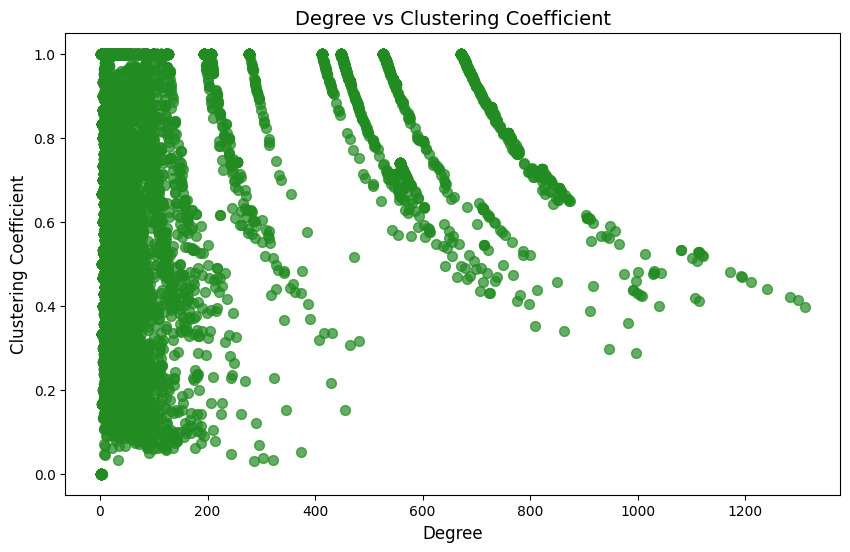

In [29]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degrees, clustering_coeffs, color="forestgreen", alpha=0.7, s=50)

# Set the title and labels
plt.title("Degree vs Clustering Coefficient", fontsize=14)
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Clustering Coefficient", fontsize=12)

# Show the plot
plt.show()

What is a bit suprprising here is that researchers with high degree almost always have a high clustering coefficient. It might that those researchers enjoy high degree because of many people working on the same paper.

TO DO:
- check the reason for researchers having top degree levels

## Assortativity

In [30]:
assortativity = nx.degree_assortativity_coefficient(RG_regular)

# Print the result
print("Degree Assortativity Coefficient:", assortativity)

Degree Assortativity Coefficient: 0.7571716390313068


Very high degree assortativity. Typical for social networks. Maybe more so in reasearchs network.

TO DO:
- Think about whether we can get some interesting node attributes for our researchers based on which we could calculate assortativity. E.g. country, university, field of research typical? 

## Centrality

### Closeness Centrality

In [22]:
# Calculate closeness centrality for all nodes
closeness_centrality = nx.closeness_centrality(RG_regular)

# Get degree for each node
degrees = dict(RG_regular.degree())

# Prepare data for plotting
degree_values = list(degrees.values())
closeness_values = list(closeness_centrality.values())

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, closeness_values, color="royalblue", alpha=0.7)

# Title and labels
plt.title("Degree vs Closeness Centrality", fontsize=14)
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Closeness Centrality", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

### Betweenness Centrality

In [ ]:
# Calculate betweenness centrality for all nodes
betweenness_centrality = nx.betweenness_centrality(RG_regular)

# Get degree for each node
degrees = dict(RG_regular.degree())

# Prepare data for plotting
degree_values = list(degrees.values())
betweenness_values = list(betweenness_centrality.values())

# Create scatter plot for Degree vs Betweenness Centrality
plt.figure(figsize=(10, 6))
plt.scatter(degree_values, betweenness_values, color="forestgreen", alpha=0.7)

# Title and labels
plt.title("Degree vs Betweenness Centrality", fontsize=14)
plt.xlabel("Degree", fontsize=12)
plt.ylabel("Betweenness Centrality", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## Cliques

Placeholder for cliques analysis.

# Communities

In [21]:
# Find the best partition (communities)
partition = community_louvain.best_partition(RG_regular)

# Calculate the modularity of the partition
modularity = community_louvain.modularity(partition, RG_regular)

# Print the modularity score
print(f"Modularity: {modularity}")

Modularity: 0.76377001237068


In [20]:
# Group nodes by community
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

# Calculate the total number of communities and average number of nodes
num_communities = len(communities)
node_counts = [len(nodes) for nodes in communities.values()]
average_nodes_per_community = sum(node_counts) / num_communities if num_communities > 0 else 0

# Print the summary
print(f"Total number of communities: {num_communities}")
print(f"Average number of nodes per community: {average_nodes_per_community:.2f}")

Total number of communities: 73
Average number of nodes per community: 538.55


### Largest Communities & Highest Modularity Contribution

In [18]:
# Sort communities by size in descending order
sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)

# Print the 5 largest communities
print("5 largest communities:")
for i, (comm_id, nodes) in enumerate(sorted_communities[:5], 1):
    print(f"Community {comm_id}: {len(nodes)} nodes")

5 largest communities:
Community 3: 12053 nodes
Community 12: 4615 nodes
Community 2: 1948 nodes
Community 11: 1772 nodes
Community 16: 1652 nodes


In [22]:
# Calculate modularity contribution for each community
community_modularity_contribution = {}
for comm_id, nodes in communities.items():
    # Get all edges between nodes in this community
    internal_edges = RG_regular.subgraph(nodes).edges()
    internal_edges_count = len(internal_edges)
    
    # Get all edges connected to nodes in this community
    total_edges = sum(RG_regular.degree(node) for node in nodes)
    
    # Calculate modularity contribution
    # Q_i = (internal edges / total edges) - (total degree / (2 * total edges))^2
    m = RG_regular.number_of_edges()
    modularity_contribution = (internal_edges_count / (2 * m)) - (total_edges / (4 * m))**2
    community_modularity_contribution[comm_id] = modularity_contribution

# Sort communities by modularity contribution in descending order
sorted_by_modularity = sorted(community_modularity_contribution.items(), key=lambda x: x[1], reverse=True)

# Print the 5 communities with highest modularity contribution
print("5 communities with highest modularity contribution:")
for i, (comm_id, mod) in enumerate(sorted_by_modularity[:5], 1):
    print(f"Community {comm_id}: {len(communities[comm_id])} nodes, modularity contribution: {mod:.4f}")


5 communities with highest modularity contribution:
Community 21: 1023 nodes, modularity contribution: 0.1149
Community 7: 773 nodes, modularity contribution: 0.0703
Community 13: 1122 nodes, modularity contribution: 0.0531
Community 5: 608 nodes, modularity contribution: 0.0531
Community 3: 12053 nodes, modularity contribution: 0.0366


## TF-IDF and wordclouds

In [89]:
# Function to get the abstracts of all papers in one community (no duplicates)
def get_community_abstracts(graph, community_id):
    accessed_papers = set()
    community_abstracts = ""

    for node in communities[community_id]:  # Iterate over nodes in the community
        for _, _, edge_data in graph.edges(node, data=True):  # Access edges and their data
            arxiv_id = edge_data.get('arxivId')  # Retrieve the 'arxivId' from edge data
            abstract = edge_data.get('abstract')  # Retrieve the 'abstract' from edge data
            if arxiv_id and arxiv_id not in accessed_papers:  # Avoid duplicates
                if abstract:
                    community_abstracts += abstract + " "  # Append the abstract
                accessed_papers.add(arxiv_id)  # Mark the paper as accessed
            
    return community_abstracts

In [90]:
# Download stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['n', 'ref', 'url', 'u','jpg','infobox', 'com','https','www','http'])
common_ai_words = ['learning', 'model', 'models', 'task', 'tasks','data','language','performance','methods','method','training']
stop_words.update(common_ai_words)

In [91]:
# Create community dicts and term frequency dicts
communities_dict = {community: get_community_abstracts(RG, community) for community in range(len(communities))}
term_frequency_community = {community: {} for community in communities_dict.keys()}

# Tokenization, filtering, and normalization
for community, text in communities_dict.items():

    tokens = re.findall('[a-zA-Z]+', text.lower())
    filtered_tokens = [word for word in tokens if word not in stop_words]

    term_frequency_community[community]['tokens'] = filtered_tokens
    
    word_freq = FreqDist(filtered_tokens)
    total_tokens = len(filtered_tokens)
    normalized_word_counts = {word: count / total_tokens for word, count in word_freq.items()}
    
    filtered_word_counts = {word: count for word, count in word_freq.items() if count >= 5}
    term_frequency_community[community]['word_count'] = filtered_word_counts
    term_frequency_community[community]['normalized_word_count'] = normalized_word_counts

In [92]:
# Calculate document frequency
doc_freq_dict_cmt = {}
for document in term_frequency_community.keys():
    for word in term_frequency_community[document]['normalized_word_count'].keys():
        if word not in doc_freq_dict_cmt:
            doc_freq_dict_cmt[word] = 0
        doc_freq_dict_cmt[word] += 1

# Calculate IDF
idf_cmt = {}
for word, doc_freq in doc_freq_dict_cmt.items():
    idf_cmt[word] = math.log10(len(term_frequency_community) / doc_freq)

# Calculate TF-IDF
for document in term_frequency_community.keys():
    term_frequency_community[document]['tf_idf'] = {}
    for word, count in term_frequency_community[document]['normalized_word_count'].items():
        tf_idf = count * idf_cmt[word]
        term_frequency_community[document]['tf_idf'][word] = tf_idf

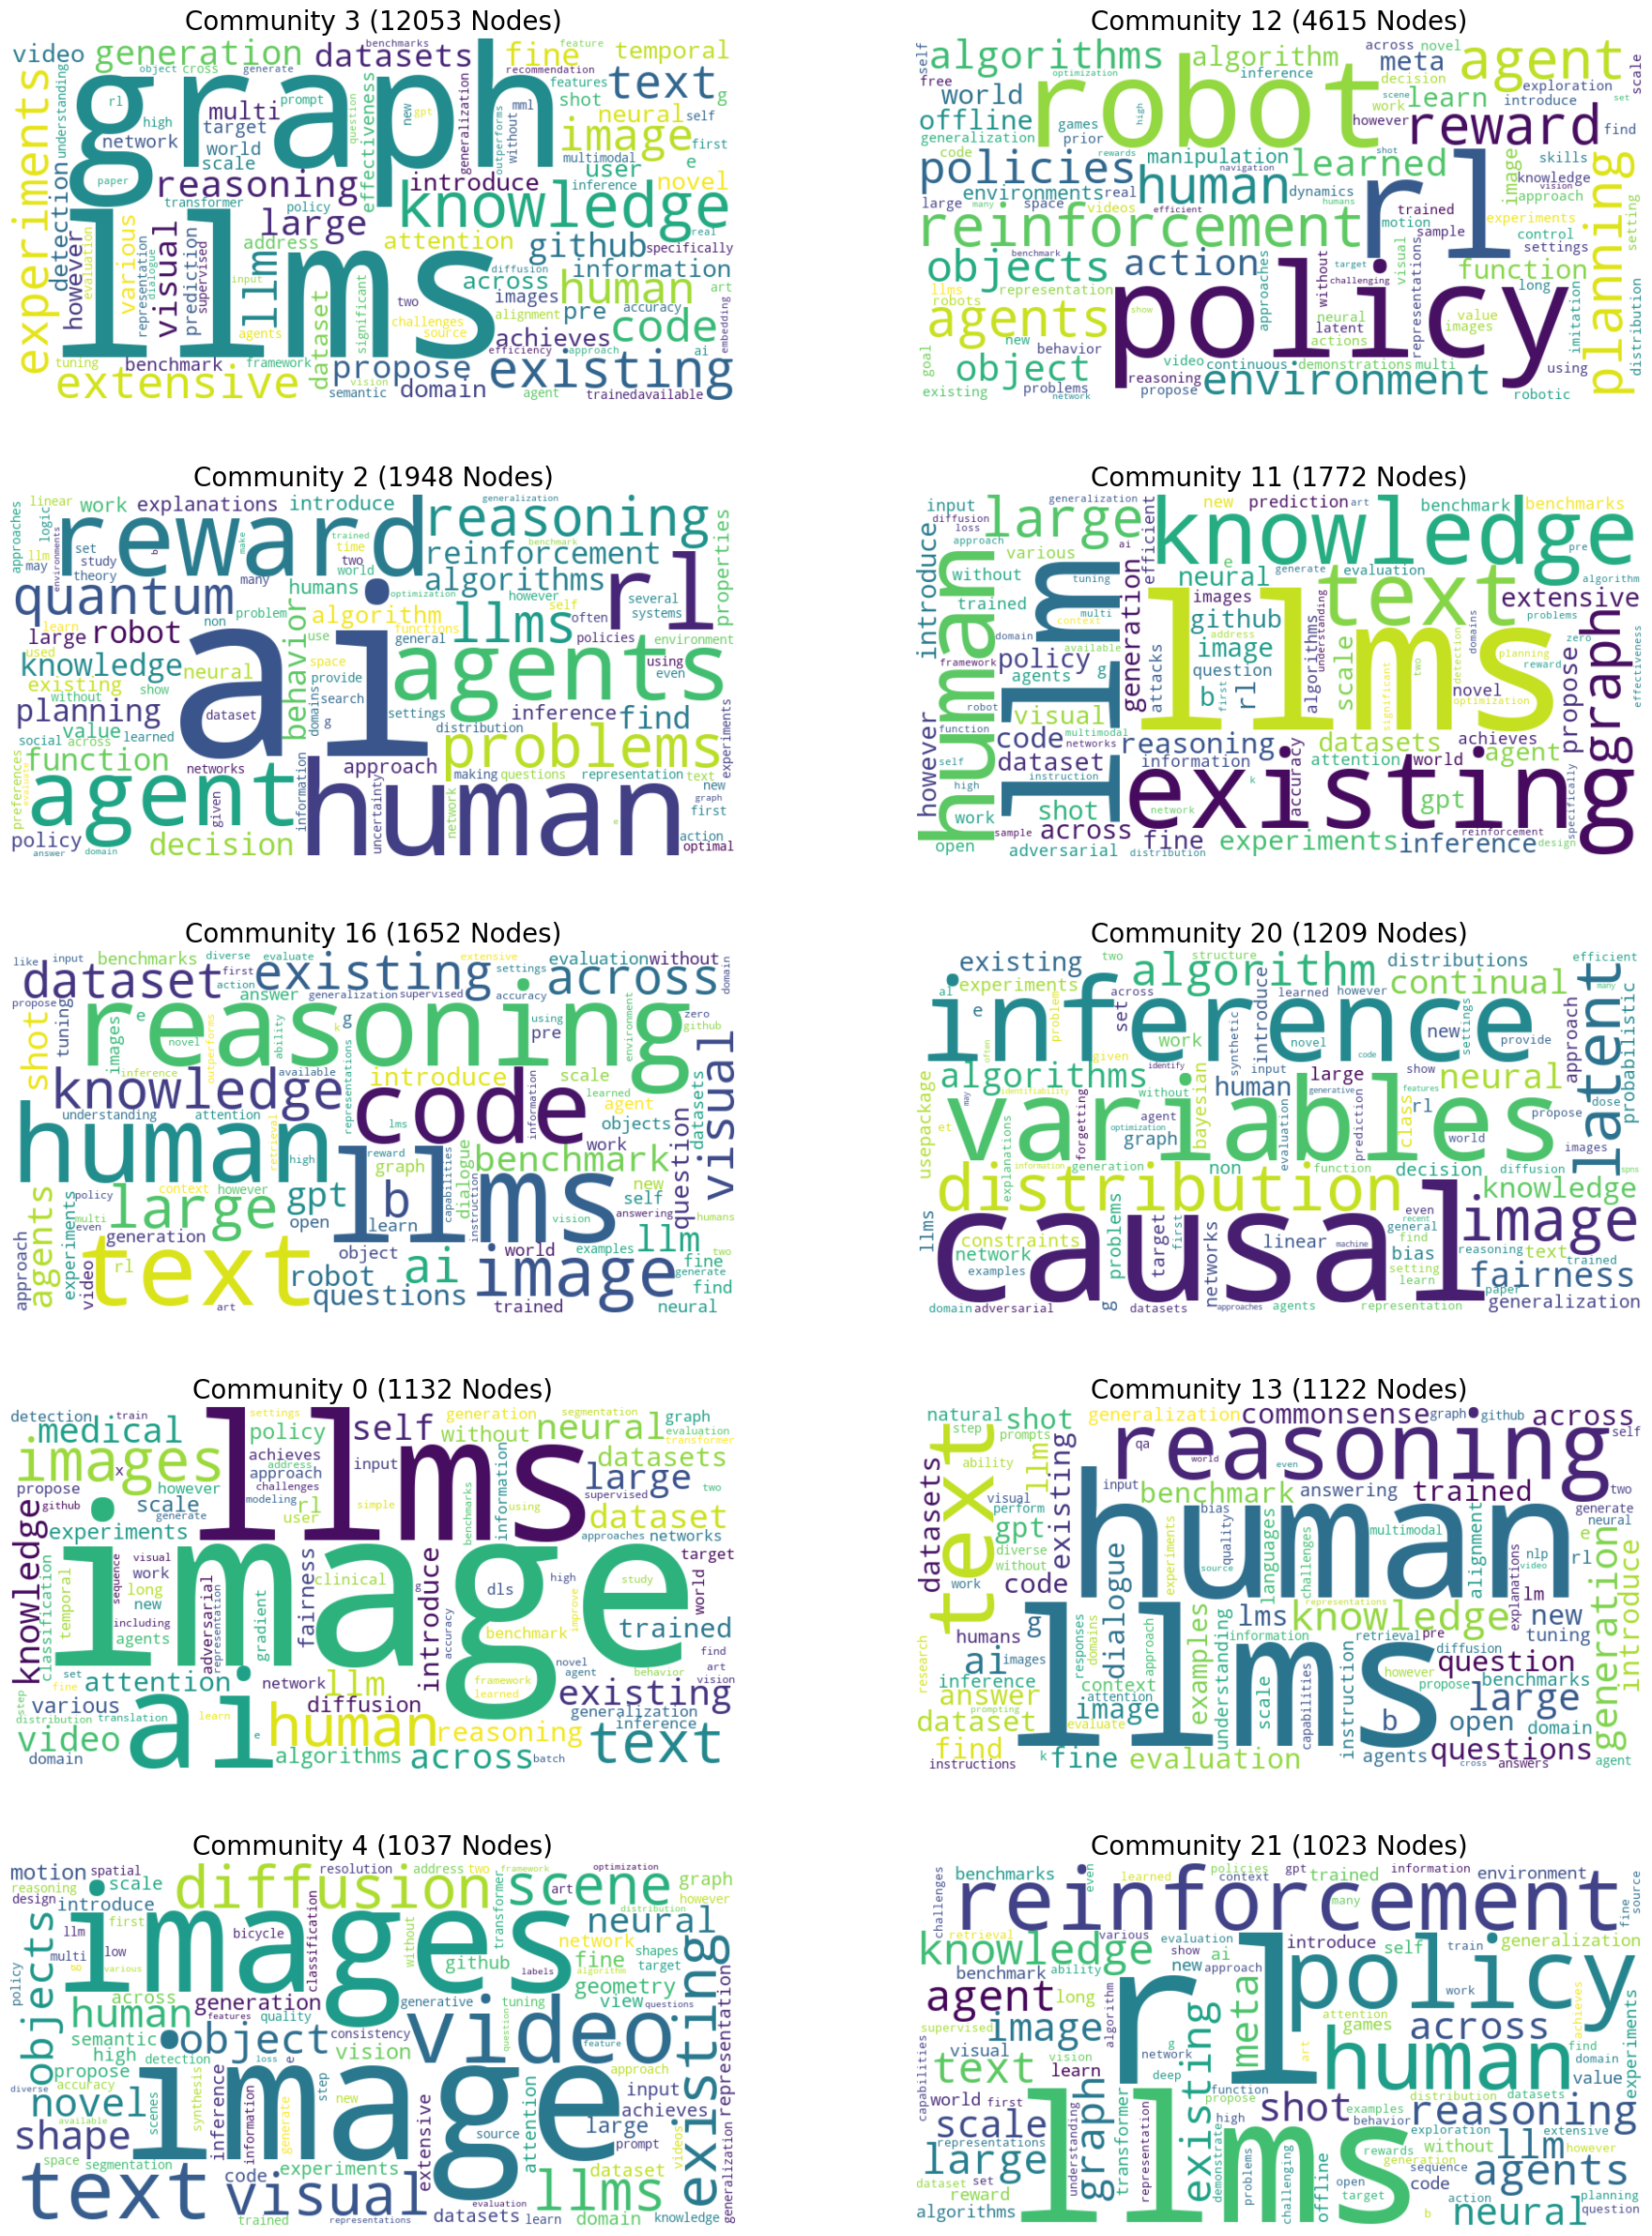

In [93]:
######## Show wordclouds for 10 largest communities #########

# Get the largest 10 communities
largest_comms = [comm_id for comm_id, _ in sorted_communities[:10]]

# Set up the word cloud parameters
wordcloud_params = {
    'background_color': 'white',
    'width': 800, 
    'height': 400,
    'max_words': 100
}

# Create word clouds only for top 10 communities
for community in largest_comms:
    if community in term_frequency_community:
        wordcloud = WordCloud(**wordcloud_params).generate_from_frequencies(term_frequency_community[community]['tf_idf'])
        term_frequency_community[community]['wordcloud_tf_idf'] = wordcloud

cols = 2
rows = 5  

# Create subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
fig.tight_layout(pad=5)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot word clouds for top 10 communities
for i, community in enumerate(largest_comms):
    if community in term_frequency_community and 'wordcloud_tf_idf' in term_frequency_community[community]:
        axes[i].imshow(term_frequency_community[community]['wordcloud_tf_idf'], interpolation='bilinear')
        axes[i].set_title(f'Community {community} ({len(communities[community])} Nodes)', fontsize=20)
        axes[i].axis('off')

plt.show()

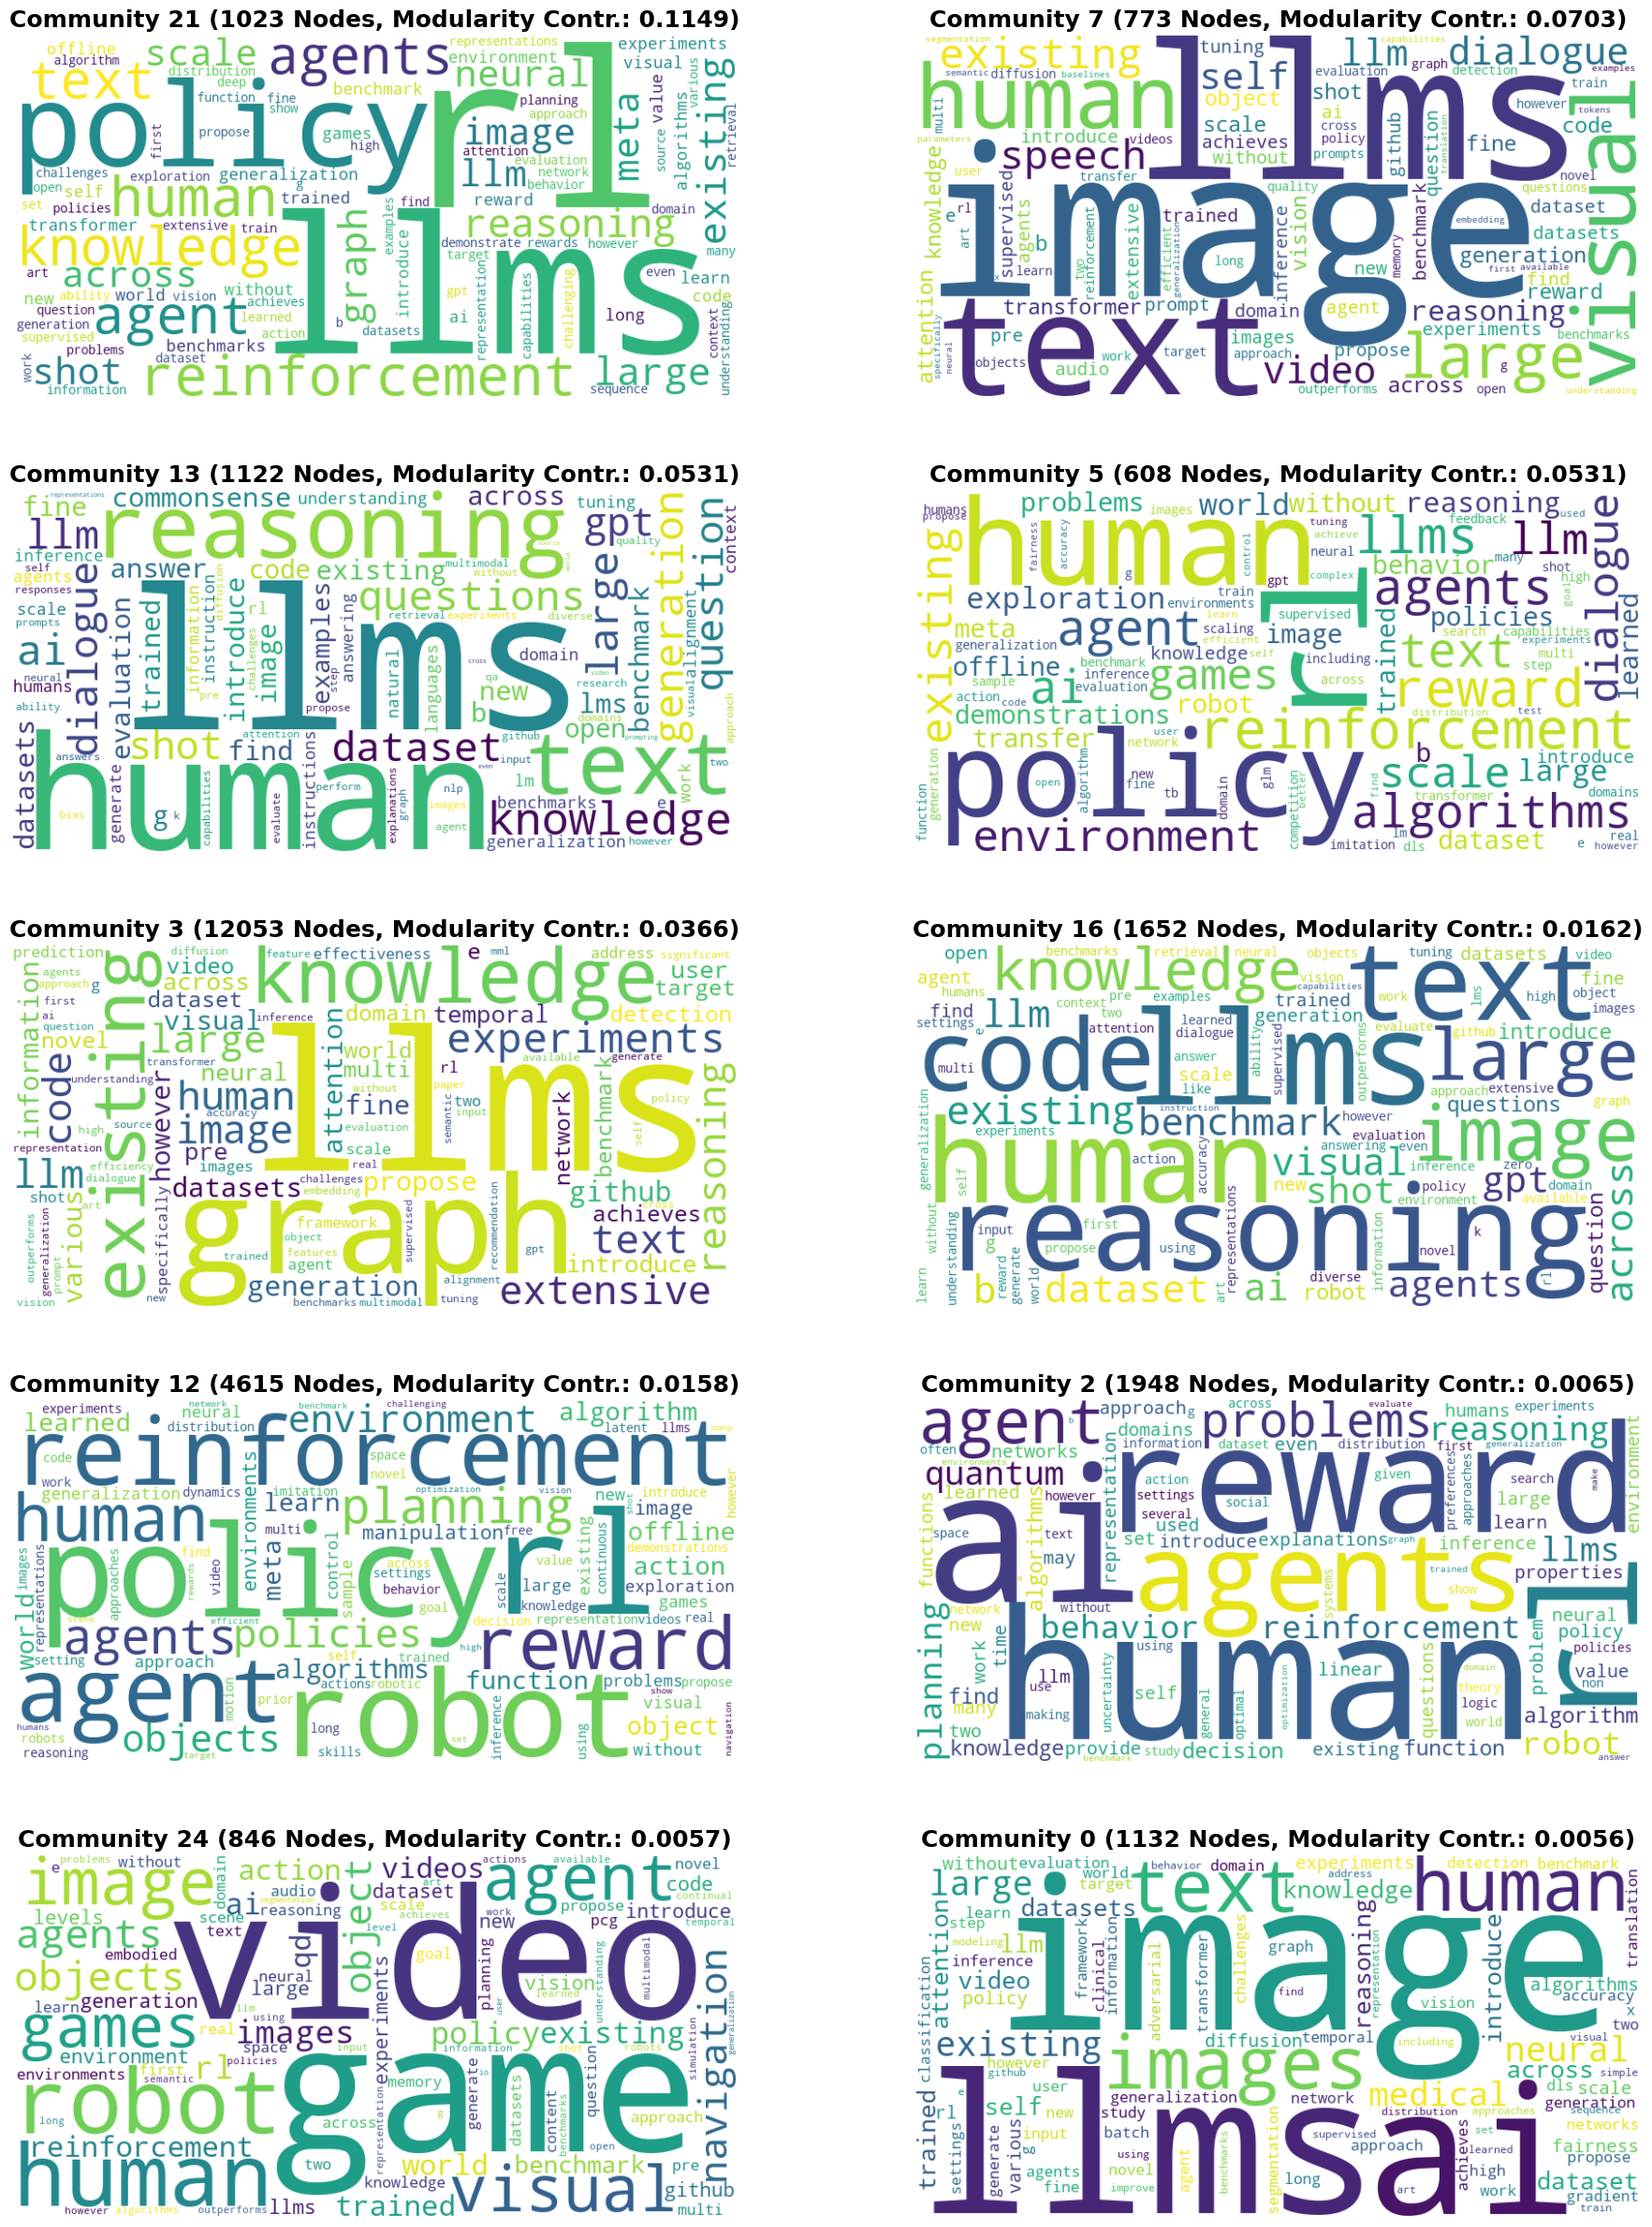

In [ ]:
######## Show wordclouds for 10 communities #########

# Get the top 10 communities by modularity contribution
modularity_comms = [comm_id for comm_id, _ in sorted_by_modularity[:10]]

# Set up the word cloud parameters
wordcloud_params = {
    'background_color': 'white',
    'width': 800,
    'height': 400,
    'max_words': 100
}

# Create word clouds only for communities with highest modularity contribution
for community in modularity_comms:
    if community in term_frequency_community:
        wordcloud = WordCloud(**wordcloud_params).generate_from_frequencies(term_frequency_community[community]['tf_idf'])
        term_frequency_community[community]['wordcloud_tf_idf'] = wordcloud


cols = 2
rows = 5  

# Create subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
fig.tight_layout(pad=5)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot word clouds for top 10 communities
for i, community in enumerate(modularity_comms):
    if community in term_frequency_community and 'wordcloud_tf_idf' in term_frequency_community[community]:
        axes[i].imshow(term_frequency_community[community]['wordcloud_tf_idf'], interpolation='bilinear')
        axes[i].set_title(f'Community {community} ({len(communities[community])} Nodes, Modularity Contr.: {community_modularity_contribution[community]:.4f})', fontsize=18, fontweight='bold')
        axes[i].axis('off')

plt.show()

TF-IDF and wordclouds show the topic of the communities. Most communities dont have a special topic, and their dominant words are standard machine learning terminology (“model”, “training”, “learning”). 

We have however also some communities where one specific topic seems to be overly present:

- **"language"**: Community 20, 18

- **"medical"** and **"image"**: Community 8

Lets have a look at the top 3 papers in each of these communities, and see whether they fit into those topics.



In [ ]:
def get_top_papers(community_id, n_papers):
    accessed_papers = set()
    top_papers = {}

    for node in communities[community_id]:
        for _, neighbor, edge_data in RG.edges(node, data=True):
            arxiv_id = edge_data.get('arxivId')
            num_cited_by = edge_data.get('numCitedBy')
            
            if arxiv_id and arxiv_id not in accessed_papers:
                top_papers[(node, neighbor)] = num_cited_by
                accessed_papers.add(arxiv_id)

    sorted_papers = sorted(top_papers.items(), key=lambda x: x[1] or 0, reverse=True)

    return dict(sorted_papers[:n_papers])

In [96]:
top_papers_cm3 = get_top_papers(3, 5)
top_papers_cm12 = get_top_papers(12, 5)
top_papers_cm21 = get_top_papers(21, 5)

In [97]:
print("--------  Top Papers Community 20 ('Language' Community)  --------")
for paper in top_papers_cm3.keys():
    print(RG_regular.get_edge_data(paper[0], paper[1]).get('title'))

print("\n--------  Top Papers Community 18 ()'Language' Community)  --------")
for paper in top_papers_cm12.keys():
    print(RG_regular.get_edge_data(paper[0], paper[1]).get('title'))

print("\n--------  Top Papers Community 8 ('Medical' & 'Image' Community)  --------")
for paper in top_papers_cm21.keys():
    print(RG_regular.get_edge_data(paper[0], paper[1]).get('title'))

--------  Top Papers Community 20 ('Language' Community)  --------
SMOTE: Synthetic Minority Over-sampling Technique
Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification
SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <1MB model size
LoRA: Low-Rank Adaptation of Large Language Models
ALBERT: A Lite BERT for Self-supervised Learning of Language Representations

--------  Top Papers Community 18 ()'Language' Community)  --------
An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
Graph Attention Networks
Conditional Generative Adversarial Nets
On the Complexity of Solving Markov Decision Problems
Overcoming catastrophic forgetting in neural networks

--------  Top Papers Community 8 ('Medical' & 'Image' Community)  --------
An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
GPT-4 Technical Report
Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Tran

**Interpretation**

We can indeed see that some communities are focussing on specific topics. Two of the five most cited papers in Community 8 are actually about images, while we don't see any image related papers in Community 20 or 18. Vice-versa, community 20 and community 18 are focussed on laguage papers. 

However, while we are able to find some communities with a light research focus, correlation seems to be relatively weak, and most communiities cover similar topics. It is therefore likely that the seperation into communities depends more on other factors, such as geography, instutions, etc. 

### Communities with the highest average citations 

In [170]:
# Dictionary to store total citations for each researcher
researcher_citations = defaultdict(int)

# Dictionary to track papers already counted for each researcher
researcher_papers = defaultdict(set)

# Traverse edges to aggregate citation counts for each researcher
for u, v, edge_data in G.edges(data=True):
    # Access citation-related attributes and title
    title = edge_data.get('title')
    num_cited_by = edge_data.get('numCitedBy', 0)
    
    # Ensure the title is valid
    if title:
        # Add citations for each researcher, ensuring the paper is counted only once
        if title not in researcher_papers[u]:
            researcher_citations[u] += num_cited_by
            researcher_papers[u].add(title)
        if title not in researcher_papers[v]:
            researcher_citations[v] += num_cited_by
            researcher_papers[v].add(title)

# Sort researchers by total citations (descending)
sorted_researcher_citations = sorted(researcher_citations.items(), key=lambda x: x[1], reverse=True)

# Print the top researchers by total citations
print("Top Researchers by Total Citations (Deduplicated by Paper):\n")
for i, (researcher, total_citations) in enumerate(sorted_researcher_citations[:10], 1):  # Adjust the range for more/less
    print(f"{i}. {researcher} - Total Citations: {total_citations}")

Top Researchers by Total Citations (Deduplicated by Paper):

1. S. Levine - Total Citations: 66585
2. P. Abbeel - Total Citations: 59345
3. Alexey Dosovitskiy - Total Citations: 41593
4. Quoc V. Le - Total Citations: 38176
5. Lucas Beyer - Total Citations: 36650
6. Xiaohua Zhai - Total Citations: 36520
7. N. Houlsby - Total Citations: 36510
8. Alexander Kolesnikov - Total Citations: 36492
9. Mostafa Dehghani - Total Citations: 36346
10. Yoshua Bengio - Total Citations: 36330


In [99]:
researcher_citations = dict(sorted_researcher_citations)

citations_community_total = {community: 0 for community in communities.keys()}
citations_community_avg = {community: 0 for community in communities.keys()}

for community in communities.keys():
    for node in communities[community]:
        citations_community_total[community] += researcher_citations[node]
    citations_community_avg[community] = citations_community_total[community] / len(communities[community])

# Sort communities by average citations (descending)
sorted_communities_by_avg = sorted(citations_community_avg.items(), key=lambda x: x[1], reverse=True)

# Print top 5 communities with highest average citations
print("Top 5 Communities by Average Citations:\n")
for i, (community, avg_citations) in enumerate(sorted_communities_by_avg[:5], 1):
    print(f"{i}. Community {community} - Average Citations: {avg_citations:.2f}")

Top 5 Communities by Average Citations:

1. Community 5 - Average Citations: 4680.64
2. Community 7 - Average Citations: 1884.74
3. Community 13 - Average Citations: 1270.20
4. Community 21 - Average Citations: 1244.08
5. Community 16 - Average Citations: 870.23


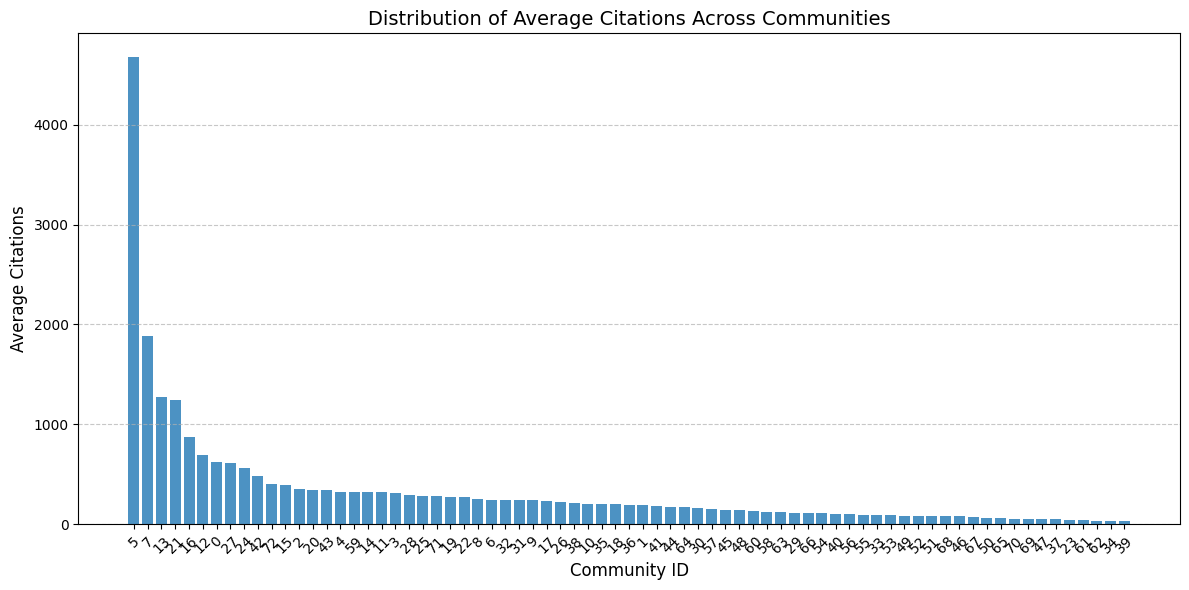

In [100]:
# Create a bar plot for average citations per community
plt.figure(figsize=(12, 6))
plt.bar(range(len(citations_community_avg)), 
        [citations for _, citations in sorted_communities_by_avg],
        alpha=0.8)

plt.title('Distribution of Average Citations Across Communities', fontsize=14)
plt.xlabel('Community ID', fontsize=12)
plt.ylabel('Average Citations', fontsize=12)

# Add community IDs as x-tick labels
plt.xticks(range(len(citations_community_avg)), 
           [community for community, _ in sorted_communities_by_avg],
           rotation=45)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [101]:
# Get researchers from community 12
community_5_citations = {researcher: citations for researcher, citations in sorted_researcher_citations 
                         if researcher in communities[5]}

# Print top 5 researchers from community 12
for i, (researcher, citations) in enumerate(list(community_5_citations.items())[:10], 1):
    print(f"{i}. {researcher}: {citations:,} citations")

1. John Schulman: 32,242 citations
2. P. Welinder: 24,595 citations
3. J. Leike: 23,320 citations
4. Wojciech Zaremba: 22,073 citations
5. Jeff Wu: 21,983 citations
6. Pamela Mishkin: 18,931 citations
7. Jie Tang: 18,874 citations
8. Chong Zhang: 18,837 citations
9. Sandhini Agarwal: 18,744 citations
10. Diogo Almeida: 18,723 citations


**Interpretation**

We have found the OpenAI mafia! 9 of 10 of the highest cited researchers in this network have (or have worked) at OpenAI.

In [102]:
# Get researchers from community 16
community_7_citations = {researcher: citations for researcher, citations in sorted_researcher_citations 
                         if researcher in communities[7]}

# Print top 5 researchers from community 16
for i, (researcher, citations) in enumerate(list(community_7_citations.items())[:10], 1):
    print(f"{i}. {researcher}: {citations:,} citations")

1. Devi Parikh: 33,969 citations
2. Naman Goyal: 12,541 citations
3. Angela Fan: 12,269 citations
4. Sharan Narang: 12,210 citations
5. J. Weston: 12,003 citations
6. Vedanuj Goswami: 11,605 citations
7. Yuning Mao: 11,490 citations
8. Shruti Bhosale: 11,457 citations
9. Eric Michael Smith: 11,325 citations
10. Sergey Edunov: 11,083 citations


**Interpretation**

Community 7 is Meta! 10/10 people of the top 10 highly cited researches have worked at Meta.

In [104]:
# Get researchers from community 25
community_21_citations = {researcher: citations for researcher, citations in sorted_researcher_citations 
                         if researcher in communities[21]}

# Print top 5 researchers from community 16
for i, (researcher, citations) in enumerate(list(community_21_citations.items())[:10], 1):
    print(f"{i}. {researcher}: {citations:,} citations")

1. N. Houlsby: 36,510 citations
2. Mostafa Dehghani: 36,346 citations
3. O. Vinyals: 19,338 citations
4. Denny Zhou: 14,610 citations
5. T. Lillicrap: 14,094 citations
6. David Silver: 13,784 citations
7. D. Hassabis: 13,249 citations
8. Yujia Li: 12,590 citations
9. Z. Chen: 12,168 citations
10. Yonghui Wu: 11,935 citations


**Interpretation**

Community 21 is Google! 9/10 people of the top 10 highly cited researches work or' have worked at Google.

#### further ideas
- shortest path lengths for all nodes (within most important communities)
- redo wordclouds for top 10 citation communities 
- reload everything + cs.ML 
